## Automated stock trading w/ reinforcement learning
---
### 목표
- 거래 패턴에서 나타나는 매수/매도 시그널을 기반으로 하는 거래 시스템
  - Reinforcement learning을 활용한
  - 단순한

---

### 사람들이 주식을 거래하는 방식

1) 오를만한 종목을 고른다
- 뉴스, 기업 분석, 거래 패턴, 감, ... -> **Prediction**

2) 매수/매도 시점, 양을 정한다
- 뉴스, 기업 분석, 거래 패턴, 감, ... -> **Policy**

### Machine learning based stock trading

- w/ Supervised learning
  - 각 종목의 가격이 오를 지(혹은 얼마나 오를 지) 예측
  - 예측된 결과를 바탕으로(사람이) 기존과 같이 매수/매도 전략 구성
- w/ Reinforcement learning
  - 최적의 전략 탐색

- 가격에 대한 예측도 큰 도움이 되지만, 언제/얼마나 사고 팔 지 결정하는 것이 어려운 문제임
  - 결국 전략을 구성해야 함 (물론 예측이 잘되면 전략을 단순하게 구성할 수 있음)
- 과거의 데이터로 알아서 (예측 필요 없이) 전략을 세울 수 있다면 베스트
  - 물론 그런 만능 모델을 만드는 것은 어렵다

### Reinforcement learning based stock trading

- RL에서는 state, action, reward를 잘 정의해야 함
  - 널리 알려진 Atari에서는 state: 화면 시퀀스, action: 키 조작(3개), reward: 점수
- Stock trading에서는 찾고자 하는 action 범위가 매우 큼
  - **어떤 종목**을, **얼마나**, **사고 팔지**
  - 종목 수 x 거래액 (Continuous) x 포지션 수 -> 풀기 어려움
  - 아직은 Continuous action에 대한 연구가 많지 않다는 한계도 있음 -> 풀기 어려움
- 하나의 종목에 대하여 Long/Short 혹은 Buy/Sell 포지션을 고르는 문제로 Formulation 하는 경우가 대부분임

![title](./img/rl-stock.jpg)


---

### 학습 목표

- 최대한 단순한 문제로 Formulation해서 작동하게 하는 것을 목표로 함
  - 우선 기존 연구와 같이 하나의 종목에 대한 전략 구성부터
  - High-frequency trading 이 아닌 Daily trading 문제로 정의함
  - 이후에 복잡한 문제(Portfolio management 등)로 Formulation, 알고리즘 고도화
- Framework도 최소한의 기능을 구현하는 것에서 시작
  - 모델 학습, 백테스팅 모듈
  - 최신 데이터 크롤링, 거래 시스템 연동, 모니터링 등은 어느 정도 성능이 나와야..

---

### Policy learning from historical data

- 실험을 위해서 인터넷에 공개된 데이터 사용
  - http://creativeworks.tistory.com/entry/코스피코스닥-주식-데이터CSV-압축파일-20170706까지
- 종목별로 일자별 데이터가 Row로 기록됨

In [1]:
! ls ../../data/experiment/* | head 

../../data/experiment/000020.csv
../../data/experiment/000030.csv
../../data/experiment/000040.csv
../../data/experiment/000050.csv
../../data/experiment/000060.csv
../../data/experiment/000070.csv
../../data/experiment/000080.csv
../../data/experiment/000100.csv
../../data/experiment/000120.csv
../../data/experiment/000140.csv


In [2]:
! head $(ls ../../data/experiment/* | head -n 1)

Date,Close,Open,High,Low,Volume,Code,Company,Up&Down,Rate
2005-04-27,11250,10750,11500,10650,31610,000020,동화약품,0.0,0.0
2005-04-28,11050,11200,11450,10950,12670,000020,동화약품,-200.0,-1.7777777777777777
2005-04-29,10900,10550,10950,10550,15280,000020,동화약품,-150.0,-1.3574660633484164
2005-05-02,11200,10900,11300,10750,71860,000020,동화약품,300.0,2.7522935779816518
2005-05-03,11700,11450,12150,11400,150848,000020,동화약품,500.0,4.464285714285714
2005-05-04,13450,13450,13450,13450,425714,000020,동화약품,1750.0,14.957264957264957
2005-05-06,13850,15000,15400,13600,984975,000020,동화약품,400.0,2.973977695167286
2005-05-09,14400,14200,14550,13600,444290,000020,동화약품,550.0,3.9711191335740073
2005-05-10,13700,14300,14650,13600,377674,000020,동화약품,-700.0,-4.861111111111112


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("../../data/experiment/000020.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

df = df[df.index >= '2011-01-01']

df.head()

,Close,Open,High,Low,Volume,Code,Company,Up&Down,Rate
Date,,,,,,,,,
2011-01-03,5280,5320,5370,5220,78725,20,동화약품,-10.0,-0.189036
2011-01-04,5300,5250,5330,5230,58101,20,동화약품,20.0,0.378788
2011-01-05,5240,5300,5350,5220,78870,20,동화약품,-60.0,-1.132075
2011-01-06,5110,5240,5250,5070,174303,20,동화약품,-130.0,-2.480916
2011-01-07,5090,5110,5150,5080,36832,20,동화약품,-20.0,-0.391389


In [5]:
import matplotlib
import matplotlib.pylab as plt

%matplotlib inline

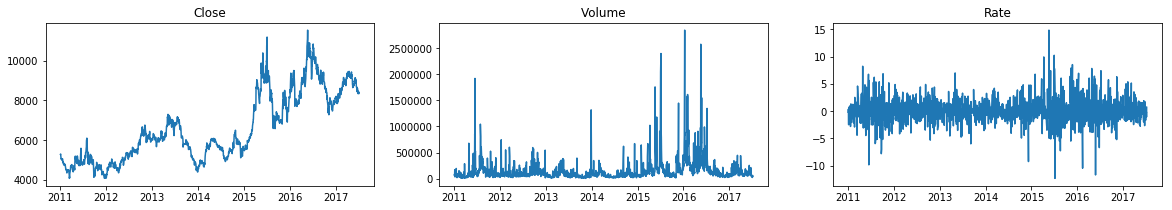

In [6]:
fig, axes = plt.subplots(1,3)

for i, c in enumerate(['Close', 'Volume', 'Rate']):
    ax = axes[i]
    ax.plot(df.index, df[c])
    ax.set_title(c)
    
fig.set_size_inches(20, 3)

위의 데이터를 기반으로 아래와 같이 접근할 계획임

- Formulation
  - state: 직전 x일의 시가/종가 등 historical 변수. High-frequency trade가 아니므로 macro 패턴을 반영하기 위한 데이터 보강 필요
  - action: 정해진 금액에 대한 Buy/Sell 
  - reward: 기간 내 수익, Sharpe Ratio 등의 지표
- Algorithm
  - Policy gradient, Actor-Critic 등 기법들의 장단점 파악 후 실험
  - state를 잘 반영하기 위한 network 구조를 설계해야 함
    - policy / value
- 학습 기간, 학습 종목, 결측치 처리, time window, reward 정의 등 기법 외적인 것이 중요할 듯

### 일단 돌려보기

- 기대 아웃풋을 살펴볼 목적으로 공개된 예제 코드로 학습함
  - blackbox
  - https://github.com/danielzak/sl-quant
- 동화약품, '2011-01-01' ~ '2017-07-05'만 사용함
  - 빠른 실험을 위해
  - 원래는 에피소드에서 그때그때 필요한 종목을 샘플링하는 것이 일반적임

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from algo1 import *

In [9]:
model, xdata, signal, learning_progress = train(df.Close)

/Users/songwon/anaconda3/envs/rl_trader/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
/Users/songwon/workspace/rl_trader/notebooks/180405/algo1.py:137: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, input_shape=(2,), kernel_initializer="lecun_uniform")`
  model.add(Dense(4, init='lecun_uniform', input_shape=(2,)))
/Users/songwon/workspace/rl_trader/notebooks/180405/algo1.py:141: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform")`
  model.add(Dense(4, init='lecun_uniform'))
/Users/songwon/workspace/rl_trader/notebooks/180405/algo1.py:145: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform")`
  model.

Epoch #: 0 Reward: 60.060393 Epsilon: 1.000000
Epoch #: 1 Reward: 0.000000 Epsilon: 0.990000
Epoch #: 2 Reward: 196.294943 Epsilon: 0.980000
Epoch #: 3 Reward: 63.869101 Epsilon: 0.970000
Epoch #: 4 Reward: -260.749999 Epsilon: 0.960000
Epoch #: 5 Reward: 171.098876 Epsilon: 0.950000
Epoch #: 6 Reward: 14.648876 Epsilon: 0.940000
Epoch #: 7 Reward: -35.743258 Epsilon: 0.930000
Epoch #: 8 Reward: 150.590449 Epsilon: 0.920000
Epoch #: 9 Reward: 77.346067 Epsilon: 0.910000
Epoch #: 10 Reward: 195.123033 Epsilon: 0.900000
Epoch #: 11 Reward: 134.183707 Epsilon: 0.890000
Epoch #: 12 Reward: 290.047752 Epsilon: 0.880000
Epoch #: 13 Reward: 181.060112 Epsilon: 0.870000
Epoch #: 14 Reward: 171.098876 Epsilon: 0.860000
Epoch #: 15 Reward: 337.510111 Epsilon: 0.850000
Epoch #: 16 Reward: 235.553932 Epsilon: 0.840000
Epoch #: 17 Reward: 91.994943 Epsilon: 0.830000
Epoch #: 18 Reward: 234.382022 Epsilon: 0.820000
Epoch #: 19 Reward: 244.343258 Epsilon: 0.810000
Epoch #: 20 Reward: 170.512921 Epsil

- 여기에서 model은 state와 value를 매핑하는 Q를 근사한 함수
- 가격/거래량의 트렌드, 반전(Peak) 등을 반영하는 네트워크 구조 필요

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
activation_2 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 20        
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [11]:
# https://github.com/danielzak/sl-quant
bt = twp.Backtest(pd.Series(data=[x[0] for x in xdata]), signal, signalType='shares')
bt.data['delta'] = bt.data['shares'].diff().fillna(0)

학습된 모델이 수행한 action을 아래와 같이 그려볼 수 있음
- 원래는 테스트를 위한 데이터를 별도로 사용해야함
  - Training/Validation/Test 데이터를 기간으로 나누는 경우가 많음
- Policy 모델이 학습되면, 각 시점에서 state를 Input으로 받아 action을 Output으로 내보냄

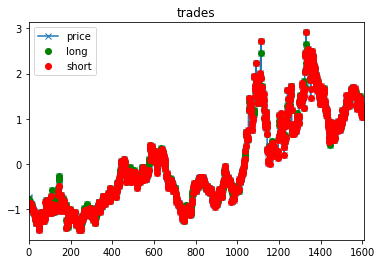

In [12]:
bt.plotTrades()

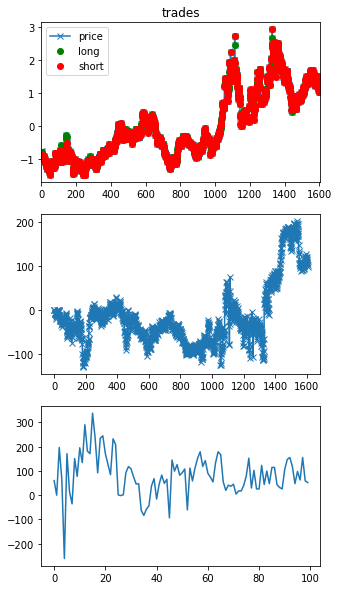

In [13]:
fig = plt.figure()
fig.set_size_inches(5, 10)

plt.subplot(3,1,1)
bt.plotTrades()
plt.subplot(3,1,2)
bt.pnl.plot(style='x-')
plt.subplot(3,1,3)
plt.plot(learning_progress)

### Backtesting

- 개발한 알고리즘을 과거의 데이터에 적용해봄으로써 기대 수익률을 계산하는 시뮬레이션
- 자신의 거래가 주가에 영향을 주지 않는다는 가정이 성립하기 때문에 가능함
- 시장이 변한다는점은 고려해야함

<img src="./img/backtest.png" alt="Drawing" style="width: 500px;"/>


- 최종 전략을 시뮬레이션하여 기대 수익률 계산
  - 수익률 / 안정성 등 검증